In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
from dataset import ASODataset
from graph_fn import onehot_reactant_batch
from trainer import Trainer
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
import torch
from torch_geometric.loader import DataLoader
from models import *

In [22]:
#hyperparameters
LEARNING_RATE = 1e-2
BATCH_SIZE = 16
NODE_INPUT_SIZE = 14
OUTPUT_SIZE_BEFORE_POOL = 30
NODE_HIDDEN_SIZE = 60
GLOB_VEC_SIZE = 10
EPOCHS = 50
DROP_OUT = 0.05
BOND_ATTR = 5

Run 1
Epoch: 050, Train Loss: 0.4538, Test Loss: 0.4764, Train MAE: 0.0481, Test MAE: 0.0563, , Train R2: 0.8373, Test R2: 0.8077
Run 2
Epoch: 050, Train Loss: 0.4492, Test Loss: 0.4708, Train MAE: 0.0375, Test MAE: 0.0451, , Train R2: 0.8908, Test R2: 0.8679
Run 3
Epoch: 050, Train Loss: 0.4527, Test Loss: 0.4755, Train MAE: 0.0457, Test MAE: 0.0561, , Train R2: 0.8327, Test R2: 0.7975
Run 4
Epoch: 050, Train Loss: 0.4510, Test Loss: 0.4721, Train MAE: 0.0422, Test MAE: 0.0473, , Train R2: 0.8626, Test R2: 0.8560
Run 5
Epoch: 050, Train Loss: 0.4501, Test Loss: 0.4723, Train MAE: 0.0411, Test MAE: 0.0496, , Train R2: 0.8704, Test R2: 0.8386
0.03911552354693413 0.046643981337547304 0.882369737631252 0.8648517788669989


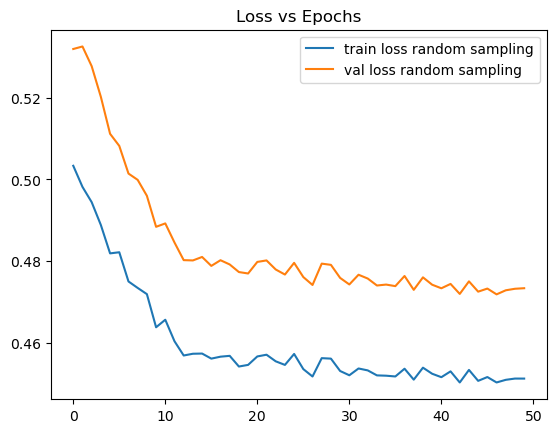

In [25]:
import numpy as np

train_loss = 0
test_loss = 0
train_R2 = 0
train_MAE = 0
test_MAE = 0
test_R2 = 0

NUM_RUN = 5
a = ASODataset(onehot_reactant_batch)

for i in range(NUM_RUN):
    print("Run " + str(i + 1))

    train_data, val_data = train_test_split(a.data, test_size = 0.1, random_state = 42)
    train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

    device = torch.device('cuda')
    model = GNNModel(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, GLOB_VEC_SIZE, num_layers=3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.95)

    t = Trainer(model, device, optimizer, scheduler, glob_v= True)
    results = t.train(train_loader, val_loader, nn.BCELoss, EPOCHS, silent = True)
    
    train_loss += np.array(t.log["train_loss"])
    test_loss += np.array(t.log["val_loss"])

    train_MAE += results[1]
    train_R2 += results[2]
    test_MAE += results[4]
    test_R2 += results[5]

train_loss /= NUM_RUN
test_loss /= NUM_RUN
train_MAE /= NUM_RUN
test_MAE /= NUM_RUN
train_R2 /= NUM_RUN
test_R2 /= NUM_RUN

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title("Loss vs Epochs")
plt.plot(train_loss, label="train loss random sampling")
plt.plot(test_loss, label = "val loss random sampling")
plt.legend()

rs_train = train_loss
rs_test = test_loss

print(train_MAE, test_MAE, train_R2, test_R2)

Run 1
Epoch: 001, Train Loss: 0.5041, Test Loss: 0.5227, Train MAE: 0.1312, Test MAE: 0.1118, , Train R2: 0.0660, Test R2: 0.1009
Epoch: 002, Train Loss: 0.4985, Test Loss: 0.5163, Train MAE: 0.1243, Test MAE: 0.1016, , Train R2: 0.1457, Test R2: 0.2212
Epoch: 003, Train Loss: 0.4968, Test Loss: 0.5138, Train MAE: 0.1233, Test MAE: 0.0996, , Train R2: 0.1653, Test R2: 0.2670
Epoch: 004, Train Loss: 0.4975, Test Loss: 0.5143, Train MAE: 0.1257, Test MAE: 0.1029, , Train R2: 0.1558, Test R2: 0.2597
Epoch: 005, Train Loss: 0.4894, Test Loss: 0.5113, Train MAE: 0.1064, Test MAE: 0.0825, , Train R2: 0.2597, Test R2: 0.3007
Epoch: 006, Train Loss: 0.4822, Test Loss: 0.5095, Train MAE: 0.0971, Test MAE: 0.0799, , Train R2: 0.3493, Test R2: 0.3186
Epoch: 007, Train Loss: 0.4770, Test Loss: 0.5021, Train MAE: 0.0957, Test MAE: 0.0776, , Train R2: 0.4307, Test R2: 0.4585
Epoch: 008, Train Loss: 0.4725, Test Loss: 0.4952, Train MAE: 0.0935, Test MAE: 0.0743, , Train R2: 0.5067, Test R2: 0.6047
Ep

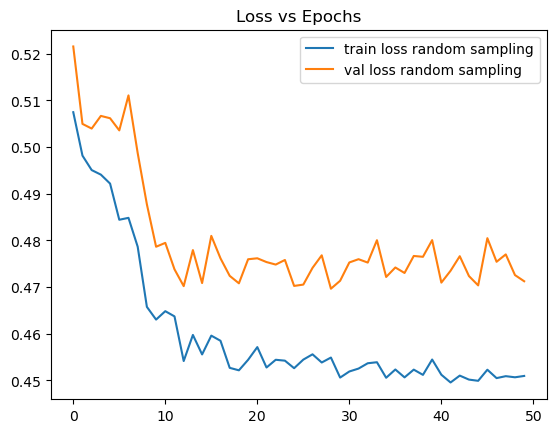

In [27]:
import numpy as np

train_loss = 0
test_loss = 0
train_R2 = 0
train_MAE = 0
test_MAE = 0
test_R2 = 0

NUM_RUN = 5
a = ASODataset(onehot_reactant_batch)

for i in range(NUM_RUN):
    print("Run " + str(i + 1))

    train_data, val_data = a.sample_test_data_catalyst_only(10,2,2)
    train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

    device = torch.device('cuda')
    model = GNNModel(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, GLOB_VEC_SIZE, num_layers=3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.95)

    t = Trainer(model, device, optimizer, scheduler, glob_v= True)
    results = t.train(train_loader, val_loader, nn.BCELoss, EPOCHS, silent = False)
    
    train_loss += np.array(t.log["train_loss"])
    test_loss += np.array(t.log["val_loss"])

    train_MAE += results[1]
    train_R2 += results[2]
    test_MAE += results[4]
    test_R2 += results[5]

train_loss /= NUM_RUN
test_loss /= NUM_RUN
train_MAE /= NUM_RUN
test_MAE /= NUM_RUN
train_R2 /= NUM_RUN
test_R2 /= NUM_RUN

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title("Loss vs Epochs")
plt.plot(train_loss, label="train loss random sampling")
plt.plot(test_loss, label = "val loss random sampling")
plt.legend()

mc_train = train_loss
mc_test = test_loss

print(train_MAE, test_MAE)

Run 1
Epoch: 050, Train Loss: 0.5210, Test Loss: 0.3872, Train MAE: 0.0731, Test MAE: 0.0574, , Train R2: 0.5963, Test R2: 0.7661
Run 2
Epoch: 050, Train Loss: 0.4508, Test Loss: 0.4890, Train MAE: 0.0495, Test MAE: 0.0956, , Train R2: 0.8433, Test R2: 0.4131
Run 3
Epoch: 050, Train Loss: 0.4990, Test Loss: 0.4044, Train MAE: 0.0490, Test MAE: 0.0770, , Train R2: 0.8149, Test R2: 0.4947
Run 4
Epoch: 050, Train Loss: 0.5088, Test Loss: 0.4123, Train MAE: 0.0551, Test MAE: 0.0858, , Train R2: 0.7990, Test R2: 0.4781
Run 5
Epoch: 050, Train Loss: 0.4391, Test Loss: 0.5158, Train MAE: 0.0531, Test MAE: 0.0943, , Train R2: 0.7997, Test R2: 0.5414
0.048648425936698915 0.06722352579236031


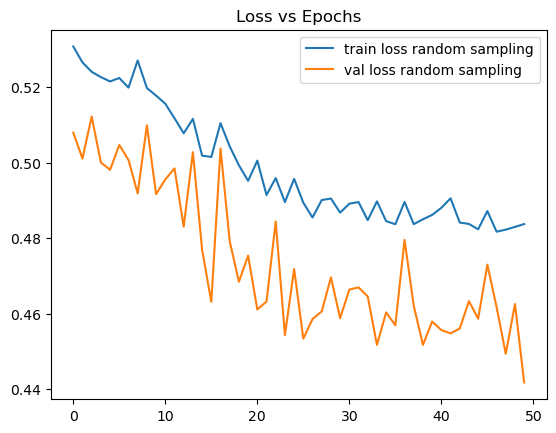

In [30]:
import numpy as np

train_loss = 0
test_loss = 0
train_R2 = 0
train_MAE = 0
test_MAE = 0
test_R2 = 0

NUM_RUN = 5
a = ASODataset(onehot_reactant_batch)

for i in range(NUM_RUN):
    print("Run " + str(i + 1))

    train_data, val_data = a.sample_test_data_reactant_only(10,2,2)
    train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

    device = torch.device('cuda')
    model = GNNModel(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, GLOB_VEC_SIZE, num_layers=3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.95)

    t = Trainer(model, device, optimizer, scheduler, glob_v= True)
    results = t.train(train_loader, val_loader, nn.BCELoss, EPOCHS, silent = True)
    
    train_loss += np.array(t.log["train_loss"])
    test_loss += np.array(t.log["val_loss"])

    train_MAE += results[1]
    train_R2 += results[2]
    test_MAE += results[4]
    test_R2 += results[5]

train_loss /= NUM_RUN
test_loss /= NUM_RUN
train_MAE /= NUM_RUN
test_MAE /= NUM_RUN
train_R2 /= NUM_RUN
test_R2 /= NUM_RUN

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title("Loss vs Epochs")
plt.plot(train_loss, label="train loss random sampling")
plt.plot(test_loss, label = "val loss random sampling")
plt.legend()

ma_train = train_loss
ma_test = test_loss

print(train_MAE, test_MAE)

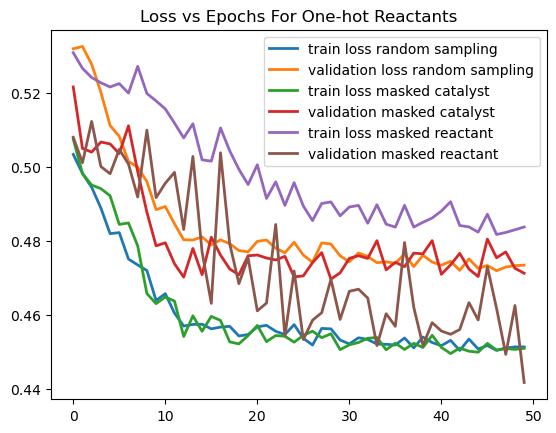

In [31]:
plt.figure()
plt.title("Loss vs Epochs For One-hot Reactants")
plt.plot(rs_train, label="train loss random sampling", linewidth=2)
plt.plot(rs_test, label = "validation loss random sampling", linewidth=2)
plt.plot(mc_train, label="train loss masked catalyst", linewidth=2)
plt.plot(mc_test, label = "validation masked catalyst", linewidth=2)
plt.plot(ma_train, label="train loss masked reactant", linewidth=2)
plt.plot(ma_test, label = "validation masked reactant", linewidth=2)
plt.legend()
plt.show()

In [32]:
mc_test.tofile('ohr_mc_test.csv', sep=',')
ma_test.tofile('ohr_mr_test.csv', sep=',')

rs_train.tofile('ohr_rs_train.csv', sep=',')
rs_test.tofile('ohr_rs_test.csv', sep=',')